# 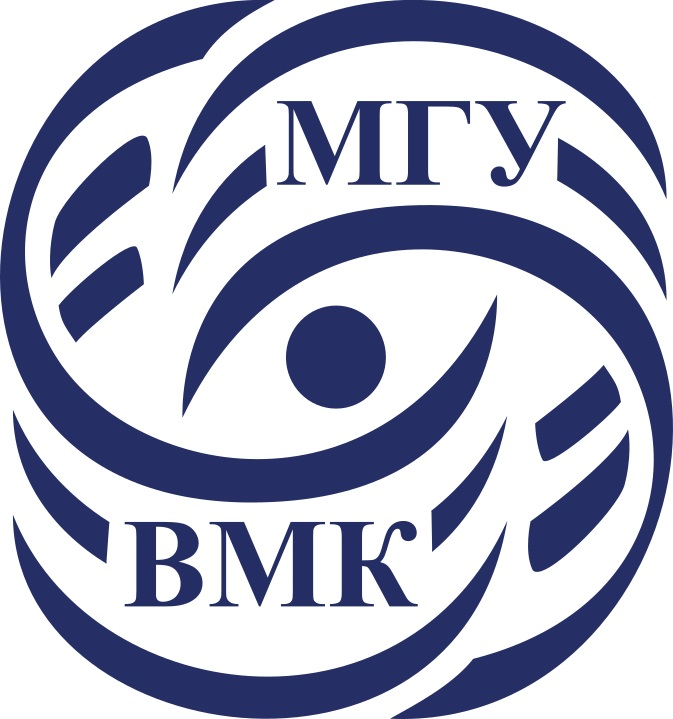

# Машинное обучение. ВМК МГУ

# Практическое задание 7: Деревья решений

## Важно! О формате сдачи.

* Практически все выделенные задания из ноутбука оцениваются по системе <font color='red'>кросс-рецензирования.</font> Задания, в которых надо реализовать свой код и послать в систему, выделены здесь и в PDF отдельно.
* В этом задании также есть задания по типу <font color='red'>unit-тестирования</font> и <font color='red'>ML-решения.</font>
* При решении ноутбука <font color='red'>используйте данный шаблон.</font> Не нужно удалять текстовые ячейки с разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно, можно.
* Везде, где в формулировке задания есть <font color='red'>какой-либо вопрос (или просьба вывода),</font> необходимо прописать ответ в ячейку (код или Markdown).
* Наличие <font color='red'>кода решения обязательно.</font> Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.
* Если в ячейке написана фраза <font color='red'>"Вывод"/"Ответ на вопрос" и.т.д.,</font> то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано <font color='red'>"Your code here" и пр. </font>, то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Вывод", и ячейка с фразой "Your code here", то в ответе ожидается и код, и текст



__В этом задании вы:__

- Посмотрите глазами, как же работают деревья решений.
- Реализуете различные меры качества разбиения в вершине.
- Посмотрите на разные методы ансамблирования деревьев решений.
- Посмотрите на поведение качества ансамбля деревьев в зависимости от числа деревьев.
- Изучите, как получить из обученного дерева важность признаков.
- Порешаете интересную физическую задачку :)

<font color=orange><h3>*Примерное время выполнения (execution time/время выполнения, если нажать run all) всех ячеек ноутбука (без ML-решения): 30 минут*</font></h3>

-----------
<font color="white" style="opacity:0.2023"></font>

## Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

**Важно!**
Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

**Важно!**
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-23-24/blob/main/tutorials/Туториал%20по%20установке%20рабочего%20окружения%20в%20Python%20для%20решения%20задач.pdf)

In [13]:
! gdown 1pIw8GdGKY6fZ_XNPc6snimdV6lbXJ199

Downloading...
From: https://drive.google.com/uc?id=1pIw8GdGKY6fZ_XNPc6snimdV6lbXJ199
To: /content/requirements_small.txt
100% 374/374 [00:00<00:00, 2.59MB/s]


**<font color='red'>Внимание!</font> Если Вы выполняете данное задание в google colab и предыдущий код выполнился с ошибкой (файл не скачался), то:**

a) Попробуйте перезапустить ядро;

б) Если не помогло, то скачайте файл вручную.

Для этого:

1. Перейдите по ссылке, указанной этом в сообщении об ошибке.
1. Скачайте файл вручную на локальный компьютер.
1. Нажмите на иконку папки в левой верхней части данного окна.
1. Вручную загрузите файл в корневую директорию (перетащив файл на область с файлами или нажав ПКМ -> загрузить).

In [14]:
! pip install -r /content/requirements_small.txt

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0


In [15]:
import catboost
assert(catboost.__version__ == '1.2.1')

-----------
<font color="white" style="opacity:0.2023"></font>

Привет, ребятушки!

Сегодня мы с вами посмотрим на такую вещь, как деревья решений. Мы попытаемся понять принцип их работы, пощупать, исследовать влияние параметров и, самое главное, узнаем, какое свойство случайных лесов оказало сильное влияние на машинное обучение.

Хочу обратить внимание, что в этом задании мы будем работать с регрессорами, однако все сделанные нами выводы верны также и для задач классификации.

**<font color='red'>Внимание!</font> При решении задач разрешается использовать ``n_jobs`` для ускорения обучения.**

**<font color='red'>Внимание!</font> Во всех заданиях в качестве целевой метрики используется MAE (средняя абсолютная ошибка).** Значение MAE вычисляется как

$$
  MAE = \sum_{i = 1}^N\dfrac{|a(x_i) - y_i|}{N},
$$

где $N$ - число объектов в тестовой выборке, $x_i$ - вектор признаков i-го объекта, $a(x_i)$ - предсказание на i-ом объекте, $y_i$ - значение целевого признака на i-м объекте.

Для вычисления MAE можно использовать встроенную функцию sklearn.metrics.mean_absolute_error.

Импортируем необходимые библиотеки:

In [16]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import fetch_california_housing
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR

import matplotlib.pyplot as plt

#####
# если Вы не различаете предлагаемые цвета, то Вы можете раскомментить строку ниже
# для применения специальной цветовой палитры или аналогичных
# plt.style.use('tableau-colorblind10')
#####

import numpy as np

import time
import os

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Задание для проверяющей системы


## <font color='orange'>Задание 0 (unit-тесты, 5 баллов)</font>

Как Вы знаете из лекций, решающие деревья на каждом шаге разбивают множество объектов на два подмножества, выбирая такой критерий, по которому разбиение наиболее оптимальное. В качестве меры качества таких разбиений могут выступать три меры: Gini, Entropy и Classification Error. Вам нужно реализовать все три меры качества и загрузить их реализацию в тестирующую систему cv-gml.ru, в задание `Деревья решений (unit-tests)`.

Подробнее об этом задании вы можете прочитать в соответствующем .pdf файле.

# Как же работают деревья решений

На лекции вам рассказывали, что деревья решений несколько раз дробят выборки, используя какие-то значения
признаков, и таким образом строят цепочки условий для принятия решения. Давайте убедимся в этом лично.

Загрузим датасет со стоимостью недвижимости в Калифорнии, который нам понадобится для первых заданий:

In [17]:
def get_california_dataset():
    """Return the splits of the California housing dataset for training and testing"""
    X, y = fetch_california_housing(return_X_y=True)
    return train_test_split(X, y, random_state=42)

X_train, X_test, y_train, y_test = get_california_dataset()

### <font color='orange'>Задание 1 (кросс-проверка, 2 балла)</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии  
**Цели**: В данном задании следует выполнить следующие пункты:

1. Обучить ``DecisionTreeRegressor`` на обучающей выборке, установив ``random_state=0``. Ограничить максимальную глубину дерева до 3, чтобы получившаяся визуализация не была слишком большой.
1. При помощи функции sklearn.tree.plot_tree визуализировать получившееся дерево. Можете передать fetch_california_housing().feature_names для улучшения визуализации. Для того чтобы визуализация выглядела лучше, можете воспользоваться аргументом fontsize, а также установить  ``plt.figure(figsize=(X,Y))``.
1. Взять любой объект из тестовой выборки. Предсказать его цену при помощи функции .predict обученного регрессора, а затем, воспользовавшись полученной визуализацией, опишите правила, по которым дерево сделало свой вывод. Опишите словами эти решения ниже.

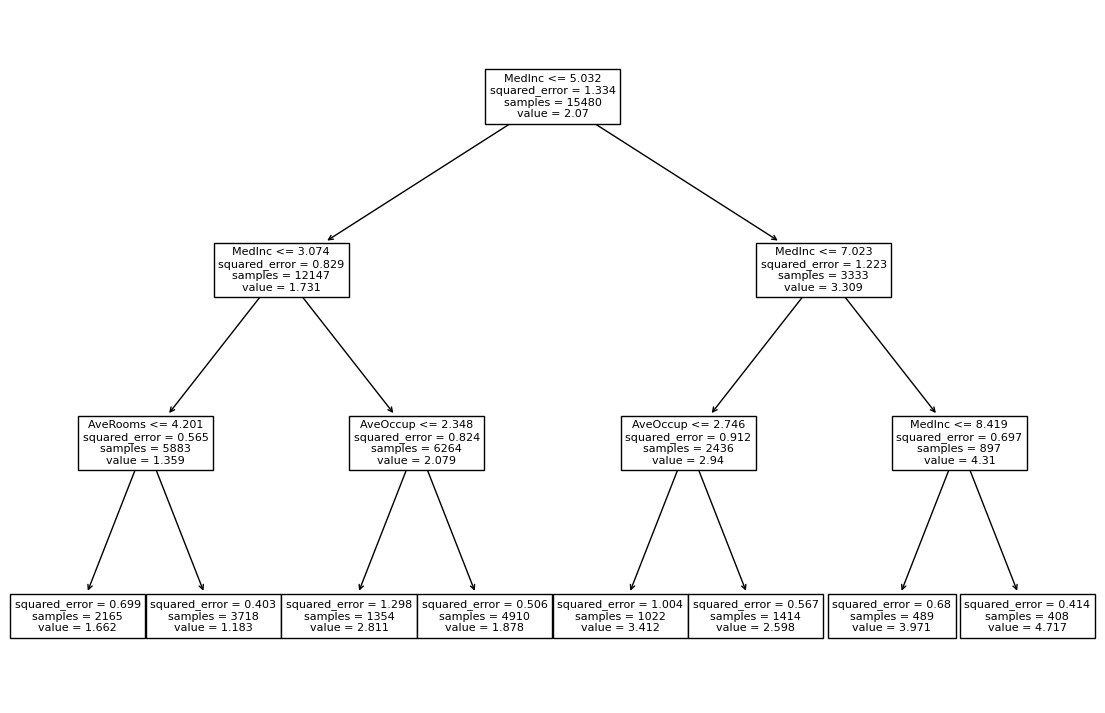

In [18]:
tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(X_train, y_train)

plt.figure(figsize=(14, 9))
plot_tree(decision_tree=tree, feature_names=fetch_california_housing().feature_names, max_depth=3)
plt.show()

In [19]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = fetch_california_housing().feature_names
table.add_row(list(X_test[0]))

print(table)

print('Predict:', tree.predict(X_test[0:1])[0])
print('True:', y_test[0])

+--------+----------+-------------------+--------------------+------------+--------------------+----------+-----------+
| MedInc | HouseAge |      AveRooms     |     AveBedrms      | Population |      AveOccup      | Latitude | Longitude |
+--------+----------+-------------------+--------------------+------------+--------------------+----------+-----------+
| 1.6812 |   25.0   | 4.192200557103064 | 1.0222841225626742 |   1392.0   | 3.8774373259052926 |  36.06   |  -119.01  |
+--------+----------+-------------------+--------------------+------------+--------------------+----------+-----------+
Predict: 1.6620208960739071
True: 0.477


**<font color='magenta'>Ответ на вопрос </font> (о том как предсказывается значение на объекте):**
Если смотреть по таблице, то в нашем случае мы двигались всегда влево по условию MedInc <= "value", так и дошли до самого глубокого значения. К сожалению, предположение далеко от правды, возможно, если бы глубина была больше или random_state ставить больше, точность была бы лучше.

-----------------------------------------------------------------------------

Мы смогли убедиться, что дерево решений действительно строит систему правил, по которым предсказывает цену недвижимости. Также мы можем убедиться, что множество возможных предсказаний регрессора сильно ограничено: все они перечислены в листовых вершинах графа. Но в чем же тогда сила деревьев решений, брат? Давайте разбираться дальше.

## Ансамбли решений

[Теорема Кондорсе о присяжных](https://neerc.ifmo.ru/wiki/index.php?title=%D0%92%D0%B8%D0%B4%D1%8B_%D0%B0%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D0%B5%D0%B9#.D0.A2.D0.B5.D0.BE.D1.80.D0.B5.D0.BC.D0.B0_.D0.9A.D0.BE.D0.BD.D0.B4.D0.BE.D1.80.D1.81.D0.B5_.D0.BE_.D0.BF.D1.80.D0.B8.D1.81.D1.8F.D0.B6.D0.BD.D1.8B.D1.85), переведённая на язык машинного обучения, гласит, что если у нас имеется некоторое количество различных методов, каждый из которых предсказывает величину лучше, чем случайно, то голосование таких методов работает лучше, чем любой из этих методов по отдельности. Давайте попробуем на простом примере проверить эту теорему.



### <font color='orange'>Задание 2.1 (кросс-проверка, 2 балла)</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии   
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить 3 дерева решений, для каждого при инициализации установить `random_state` равный 1, 2 и 3. В этот раз ограничивать глубину деревьев не нужно.
1. Получить предсказание для тестовой выборки от каждого регрессора, а также получить ``усреднённое`` предсказание.
1. Посчитать MAE для каждого из деревьев, полученных в первом пункте, а также для усреднённых предсказаний. Сделать вывод о том, стало лучше или нет.

In [20]:
tree1 = DecisionTreeRegressor(random_state=1)
tree2 = DecisionTreeRegressor(random_state=2)
tree3 = DecisionTreeRegressor(random_state=3)

tree1.fit(X_train, y_train)
tree2.fit(X_train, y_train)
tree3.fit(X_train, y_train)

y_pred1 = tree1.predict(X_test)
y_pred2 = tree2.predict(X_test)
y_pred3 = tree3.predict(X_test)

avg_pred = (y_pred1 + y_pred2 + y_pred3) / 3.0

print(f'MAE (random_state=1) = {mean_absolute_error(y_test, y_pred1)}')
print(f'MAE (random_state=2) = {mean_absolute_error(y_test, y_pred2)}')
print(f'MAE (random_state=3) = {mean_absolute_error(y_test, y_pred3)}')
print(f'Average MAE = {mean_absolute_error(y_test, avg_pred)}')

MAE (random_state=1) = 0.46331883139534885
MAE (random_state=2) = 0.4645068275193799
MAE (random_state=3) = 0.46247640503875975
Average MAE = 0.4542563636950904


Надеюсь, мы смогли убедиться, что это действительно работает. Правда, улучшение достаточно маленькое и для прорыва в машинном обучении этого еще недостаточно.

А что влияет на улучшение, которое мы получаем при использовании ансамбля методов? Соответствующая теорема дает достаточно простой ответ: различность методов и ведет к улучшению. Если у нас есть много методов, предсказания которых отличаются незначительно, то их усреднение практически ничего не изменит. Если же у нас есть множество достаточно разных методов, то и их усреднение будет отличаться от предсказаний каждого отдельного метода. Видимо, random_state было недостаточно. Как же нам еще сильнее увеличить различность методов? Ответ вы знаете: использовать случайные признаки и случайную выборку объектов. Это приводит нас к случайным лесам.

### <font color='orange'>Задание 2.2 (кросс-проверка, 1 балл)</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии    
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Обучить RandomForestRegressor. Для честности следует установить ``n_estimators=3``, то есть сделать число деревьев равным 3 (как мы сделали в предыдущем задании). Для однородности также поставьте ``random_state = 0``
1. Посчитать MAE полученных предсказаний. Сравнить их с результатами, полученными в предыдущем пункте. Сделайте вывод.

In [21]:
forest = RandomForestRegressor(n_estimators=3, random_state=0)
forest.fit(X_train, y_train)
pred = forest.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, pred)}')

MAE: 0.3910999521963824


**<font color='magenta'>Вывод по результату</font>**:

Вспомним, что было до этого:

MAE (random_state=1) = 0.46331883139534885

MAE (random_state=2) = 0.4645068275193799

MAE (random_state=3) = 0.46247640503875975

Average MAE = 0.4542563636950904

Получается, результаты улучшились, то есть случайный лес ближе к правде, чем ансамбли решений.

-----------------------------------------------------------------------------

Для прорывов и этого, кажется, маловато. Давайте продолжим исследовать случайные леса.

## Переобучение и зависимость предсказаний от числа деревьев

В прошлом задании мы вручную установили число деревьев в лесу равное трем, чтобы более честно сравниваться с нашим предыдущим ансамблем. Давайте изучим влияние этого параметра на результат предсказаний.



### <font color='orange'>Задание 3.1 (кросс-проверка, 2 балла)</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии     
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучите 10 случайных лесов, установив random_state=42 и замерив время, потраченное на обучение. Для обучаемых лесов, используйте число деревьев (`n_estimators`) из `np.logspace(1, 3, num=10)` (округлите значения вниз до целых чисел). Таким образом мы получим оценку результата для лесов, построенных с различным числом деревьев.
1. Для всех 10 лесов посчитайте MAE на тренировочном и тестовом множествах.
1. Постройте график для отображения зависимости времени обучения от числа деревьев в лесу. Вдоль оси Ox отложите число деревьев, участвующих в обучении. На оси Oy отложите время, потраченное на обучение.
1. Постройте график для отображения зависимости значения MAE от числа деревьев в лесу. Вдоль оси Ox отложите число деревьев, участвующих в обучении. На оси Oy отложите одним цветом значение MAE на тренировочном множестве, другим цветом MAE на тестовом множестве.
1. Проанализируйте результаты и графики, сделайте выводы про время обучения при различном числе деревьев и про качество результатов (в частности - переобучение)

In [22]:
MAE_train, MAE_test, stopwatch = list(), list(), list()
numbers = np.logspace(1, 3, num=10).astype(int)

for n in numbers:
    forest = RandomForestRegressor(n_estimators=n, random_state=42)

    start = time.time()
    forest.fit(X_train, y_train)
    finish = time.time()

    stopwatch.append(finish - start)
    MAE_train.append(mean_absolute_error(y_train, forest.predict(X_train)))
    MAE_test.append(mean_absolute_error(y_test, forest.predict(X_test)))

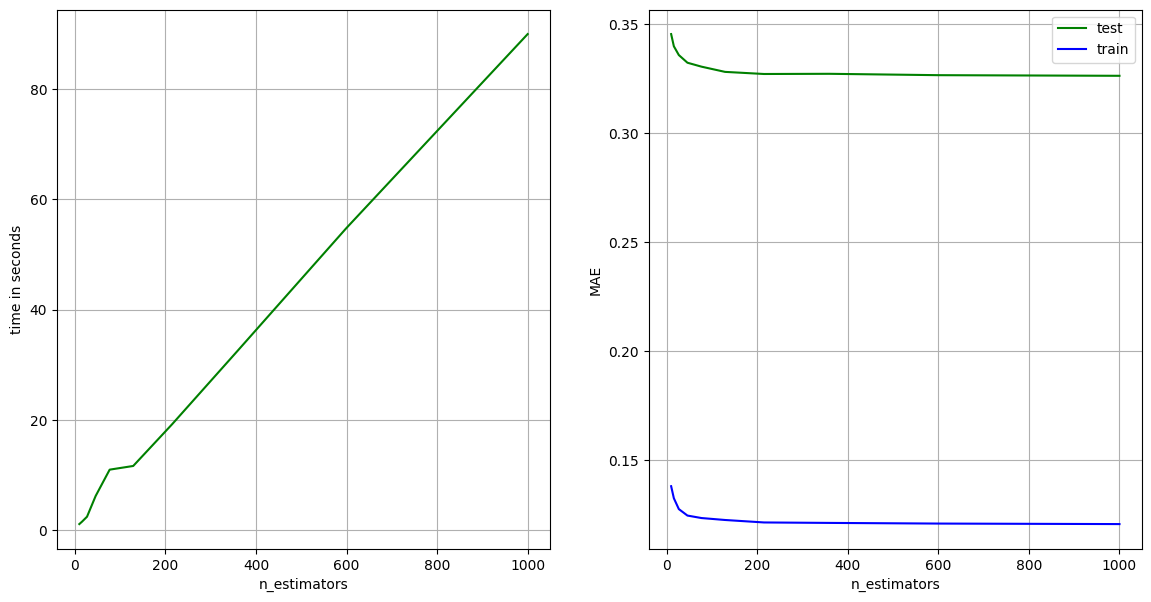

In [23]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.xlabel('n_estimators')
plt.ylabel('time in seconds')
plt.plot(numbers, stopwatch, color='g')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(numbers, MAE_test, color='g')
plt.plot(numbers, MAE_train, color='b')
plt.xlabel('n_estimators')
plt.ylabel('MAE')
plt.legend(['test', 'train'])
plt.grid()

plt.show()

**<font color='magenta'>Ваши выводы:</font>**
1.   Время линейно зависит от числа деревьев
2.   MAE на маленьком числе деревьев больше, чем на бОльшем количестве. Также можно заметить устойчивость при увеличении числа деревьев. То есть значение метрики стремится к константному значению при увеличении количества дереьев
3.  Переобучения в данном случае не наблюдалось(его бы можно было заметить, если график справа не просто уменьшался всегда, а имел бы место небольшой скачок вверх)

-----------------------------------------------------------------------------


Как мы с вами знаем, случайный лес постепенно улучшает качество предсказаний, увеличивая число деревьев в ансамбле. А что если мы уже обучили лес, но хотим `нарастить` его, добавив несколько деревьев? Или даже если к нам пришли новые данные и мы хотим добавить деревьев, обученных на них, но не удалять деревья, построенные на предыдущих данных? Такой трюк возможен, и для этого следует использовать warm_start. То, как правильно использовать warm_start можно глянуть [тут](https://stackoverflow.com/questions/42757892/how-to-use-warm-start/42763502)

### <font color='orange'>Задание 3.2 (кросс-проверка, 3 балла)</font>
**Данные**: датасет со стоимостью недвижимости в Калифорнии     
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  

1. Создайте случайный лес со следующими параметрами: n_estimators = 100, warm_start = True, random_state=42
2. Обучите полученный лес, засекая время, потраченное на обучение, и измерив качество предсказания на тесте по MAE
3. Увеличьте число деревьев в лесу. Для этого увеличьте число regressor.n_estimators на 100.
4. Воспользуйтесь методом fit, чтобы дообучить новые деревья. Не забудьте замерить время и качество!
5. Повторяйте два предыдущих шага до тех пор, пока вы не вырастите лес с 1000 деревьями.
6. Постройте графики зависимости качества и времени обучения от количества деревьев (время считайте отдельно для каждого дообучения, без учета затрат на предыдущие итерации)
7. Проанализируйте результаты и графики, сделайте выводы про время обучения и качество, сравните с результатом из предыдущего пункта

In [24]:
stopwatch, mae = list(), list()

forest = RandomForestRegressor(n_estimators=100, random_state=42, warm_start=True)

start = time.time()
forest.fit(X_train, y_train)
end = time.time()
mae.append(mean_absolute_error(y_test, forest.predict(X_test)))
stopwatch.append(end - start)

for _ in range(9):
  forest.n_estimators += 100

  start = time.time()
  forest.fit(X_train, y_train)
  end = time.time()
  mae.append(mean_absolute_error(y_test, forest.predict(X_test)))
  stopwatch.append(end - start)

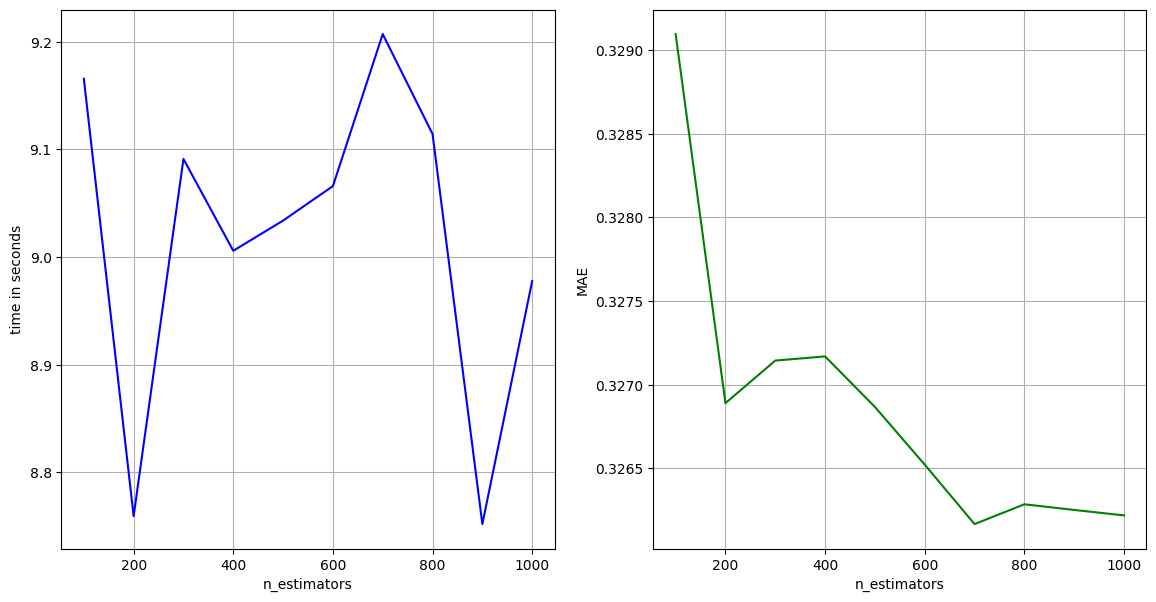

In [25]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.xlabel('n_estimators')
plt.ylabel('time in seconds')
plt.plot(range(100, 1001, 100), stopwatch, color='b')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(100, 1001, 100), mae, color='g')
plt.xlabel('n_estimators')
plt.ylabel('MAE')
plt.grid()

plt.show()

**<font color='magenta'>Ваши выводы:</font>**

1.   Время дообучения скачет от 8,8 до 10 секунд, причем приозошел скачок вверх при 500 деревьях
2.   MAE в основном уменьшается, но бывали моменты, когда лес перееобучался (на значениях 300, 400 и 800). Причем значения колеблятся рядом со стабильным значением из предыдущего задания


## Важность признаков

С этого момента мы изменим датасет и попытаемся поиграться с физикой: возьмем коллекцию различных потенциалов и для них будем предсказывать некоторую физическую величину. Обученные физики говорят, что эта величина зависит от формы и глубины потенциала, а значит и мы можем тут чему-то научиться. Ранее эту задачу пытались решить с помощью сверточных нейронных сетей. А получится ли это у нас с помощью деревьев?

Загрузим датасет и посмотрим как он выглядит:

**<font color='red'>Внимание!</font>** Для выполнения этого задания вам понадобится публичный датасет из задания `Деревья решений (ML)` на cv-gml.ru.

Если вы выполняете задание в <font color='red'>Google Colab</font>, то можете пропустить дальнейший текст - данные скачаются в следующей ячейке кода.

Если вы делаете <font color='red'>локально</font>, то, пожалуйста, выполните эти пункты:

1. Скачайте архив `Шаблон решения` задания `Деревья решений (ML)` и разархивируйте его в любом удобном для вас месте.
2. Найдите переменную `path_to_dataset`, расположенную на первой строке ячейки после загрузки данных, и измените её значение на полный путь до папки `[ПАПКА_ИЗВЛЕЧЕНИЯ]/public_tests/01_test_potentials_input/train/potentials`


In [26]:
!pip install --upgrade --no-cache-dir gdown # Нужно для возможности скачать zip; Перезапускать ноутбук НЕ НУЖНО!
!gdown 1l7bH623Jmdj-3pKSwhBgxlhkyZJ8xyCv


  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
Downloading...
From (original): https://drive.google.com/uc?id=1l7bH623Jmdj-3pKSwhBgxlhkyZJ8xyCv
From (redirected): https://drive.google.com/uc?id=1l7bH623Jmdj-3pKSwhBgxlhkyZJ8xyCv&confirm=t&uuid=37beb0ff-bad0-45c5-99b8-43ce3ed70ade
To: /content/trees_public_tests.zip
100% 27.8M/27.8M [00:00<00:00, 92.8MB/s]


**<font color='red'>Внимание!</font> Если Вы выполняете данное задание в google colab и предыдущий код выполнился с ошибкой (файл не скачался), то Вам нужно будет скачать его вручную**.

Для этого:

1. Перейдите по ссылке, указанной этом в сообщении об ошибке.
1. Скачайте файл вручную на локальный компьютер.
1. Нажмите на иконку папки в левой верхней части данного окна.
1. Вручную загрузите файл в корневую директорию (перетащив файл или нажав ПКМ -> загрузить).

In [27]:
!unzip -d ./public_tests -u /content/trees_public_tests.zip

Archive:  /content/trees_public_tests.zip


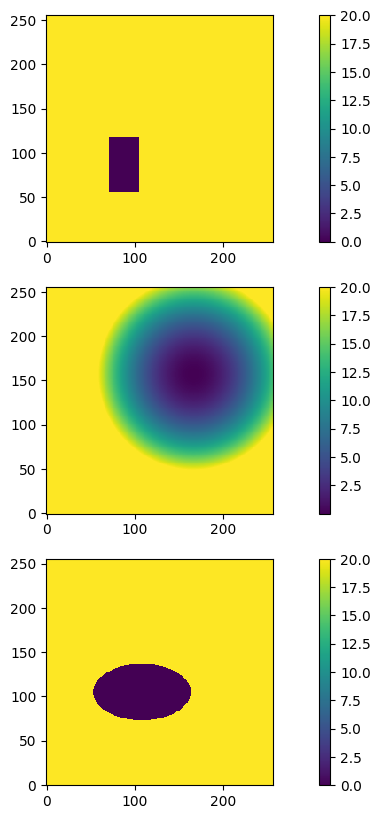

In [28]:
path_to_dataset = "/content/public_tests/01_test_potentials_input/train/potentials"

chosen_ones = {'b2399918793e4228a3ea0a0a89adf11b.npz', '513d5523d14c47feb8b544138071c496.npz', 'ca9f96c404b740e3b28f583f9d9afbf8.npz'}

plt.figure(figsize=(12, 10))

def get_potential_dataset():

    global path_to_dataset

    """Return the training and testing splits of the potential dataset"""
    X, y = [], []

    plot_index = 1

    if not path_to_dataset.endswith("/"):
        path_to_dataset += "/"

    for f in os.listdir(path_to_dataset):

        npz = np.load(f'{path_to_dataset}{f}')
        data, target = npz['data'], npz['target']

        X.append(data)
        y.append(target)

        if f in chosen_ones:
            plt.subplot(len(chosen_ones), 1, plot_index)
            plt.imshow(data, origin="lower", interpolation='none')
            plt.colorbar()
            plot_index += 1
    plt.show()
    return train_test_split(np.array(X), np.array(y), random_state=42)

X_train, X_test, y_train, y_test = get_potential_dataset()



Можно увидеть, что у нас имеется три типа потенциалов: два с бесконечно крутыми стенками: квадратный и эллиптический (их значение резко меняется на 0). Также у нас имеется гармонический потенциал (красивый и круглый, он плавно спускается к своему минимуму). В местах, где потенциала нет, значение матрицы равно 20.

В глаза бросается одна проблема: матрицы у нас квадратные (каждая картинка `256 х 256`), а большинство методов машинного обучения работает с векторами-признаками. К сожалению, нам придется с этим позже разобраться. Но есть еще более крупная проблема: потенциалы находятся в "случайных" местах рисунка, и оставлять это без внимания нельзя. Но вернёмся к нашим баранам. У линейных регрессоров есть одно очень полезное свойство: после обучения мы ``из коробки`` получаем важность признаков: чем выше значение коэффициента (или абсолютное значение) стоящего у признака, тем этот признак важнее. Деревья решений не обладают столь же ``естественной`` оценкой важности признаков, однако мы всё равно можем её получить. Называется эта оценка критерием Джини: она вычисляет то, как начинают ``ошибаться`` предсказания регрессора, если исключить данный признак. Чем сильнее ошибка, тем важнее признак. К нашей радости, sklearn так же ``из коробки`` включает данные оценки признаков. Давайте попробуем воспользоваться этой функцией и посмотреть на важность признаков.

План наших действий следующий. Во-первых, мы должны преобразовать квадратные матрицы в векторы. Для простоты воспользуемся обычным reshape, что сможет гарантировать нам устойчивость преобразования. Получив вектор, мы воспользуемся методами машинного обучения и получим вектор, характеризующий важность каждого признака. Далее, с целью визуализации этого вектора важностей и возможности его сопоставления с оригинальными изображениями, воспользуемся обратным reshape в исходную размерность. Reshape работает таким образом, что если мы сделаем всё верно, то важности признаков попадут в те же пиксели, которым они соответствуют в исходных изображениях. Давайте попробуем это!

### <font color='orange'>Задание 4.1 (кросс-проверка, 4 балла)</font>
**Данные**: потенциалы  
**Метрика качества**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Воспользоваться классом PotentialTransformer для преобразования двумерной матрицы в одномерный вектор
2. Воспользоваться классом Pipeline, чтобы "объединить" трансформатор и обучаемый метод
3. Обучить LinearSVR из sklearn на этом датасете.
4. Обучить RandomForestRegressor из sklearn на этом датасете.
5. Извлеките важность признаков из обученного леса с помощью `feature_importances_`. Извлеките также коэффициенты svm через coef_ (брать абсолютные значения необязательно).
6. Преобразуйте одномерный вектор важностей признаков в двумерную картинку таким образом, чтобы их можно было сравнивать с исходными потенциалами. Постройте рисунки важностей признаков с помощью plt.imshow. Добавьте легенду.
7. Оцените качество предсказаний через метод .predict.
8. Проанализируйте результаты. Можно ли сказать что у обоих методов получились одинаковые важности признаков? Можно ли сказать, что важность признаков отображает структуру потенциалов?

In [29]:
class PotentialTransformer:
    """
    A potential transformer.

    This class is used to convert the potential's 2d matrix to 1d vector of features.
    """

    def fit(self, x, y):
        """
        Build the transformer on the training set.
        :param x: list of potential's 2d matrices
        :param y: target values (can be ignored)
        :return: trained transformer
        """
        return self

    def fit_transform(self, x, y):
        """
        Build the transformer on the training set and return the transformed dataset (1d vectors).
        :param x: list of potential's 2d matrices
        :param y: target values (can be ignored)
        :return: transformed potentials (list of 1d vectors)
        """
        return self.transform(x)

    def transform(self, x):
        """
        Transform the list of potential's 2d matrices with the trained transformer.
        :param x: list of potential's 2d matrices
        :return: transformed potentials (list of 1d vectors)
        """
        return x.reshape((x.shape[0], -1))

# Your code here:
svr = Pipeline([('vectorizer', PotentialTransformer()), ('regressor', LinearSVR())])
forest = Pipeline([('vectorizer', PotentialTransformer()), ('regressor', RandomForestRegressor())])
svr.fit(X_train, y_train)
forest.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 <__main__.PotentialTransformer object at 0x7d248a5fb610>),
                ('regressor', RandomForestRegressor())])

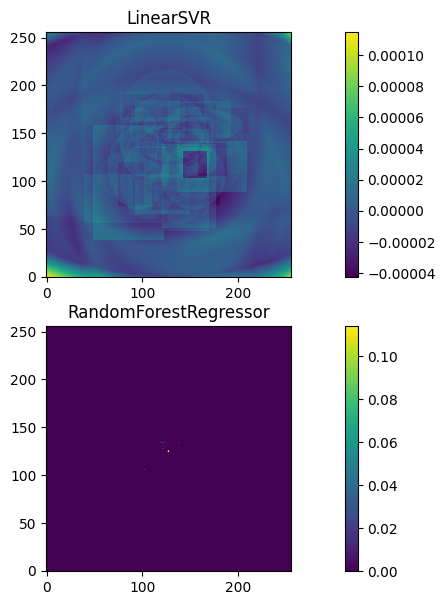

In [30]:
feature_importances_svr = svr['regressor'].coef_.reshape(256, 256)
feature_importances_forest = forest['regressor'].feature_importances_.reshape(256, 256)

plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.title('LinearSVR')
plt.imshow(feature_importances_svr, origin="lower", interpolation='none')
plt.colorbar()

plt.subplot(2, 1, 2)
plt.title('RandomForestRegressor')
plt.imshow(feature_importances_forest, origin="lower", interpolation='none')
plt.colorbar()

plt.show()

In [31]:
print(f"MAE (linear SVR): {mean_absolute_error(y_test, svr.predict(X_test))}")
print(f"MAE (random forest): {mean_absolute_error(y_test, forest.predict(X_test))}")

MAE (linear SVR): 0.0881162217849059
MAE (random forest): 0.04676023708424738


**<font color='magenta'>Ваши выводы:</font>** (ВПИШИТЕ СЮДА ТЕКСТОМ)

*   Оба метода проявили различные особенности в определении важности признаков. Модель LinearSVR выделила потенциалы, отображая их структуры на признаках и подстраиваясь под обучающую выборку. С другой стороны, RandomForestRegressor стремился случайным образом выбирать важные признаки, что позволило ему немного обобщить структуру потенциалов. В результате на тестовой выборке RandomForestRegressor продемонстрировал более высокое качество по сравнению с LinearSVR.

*   Лес показал более успешные результаты по сравнению с SVR. Важность признаков в лесу оказалась невелика и точечна, преимущественно множество признаков имели значение ноль. В отличие от этого, у LinearSVR важность признаков была выражена почти везде. Однако стоит отметить, что важность признаков в обоих случаях не смогла полностью отразить структуру потенциалов, хотя в случае SVR форма как-то "запомнилась".

*   Важности признаков в обоих случаях оказались абсолютно разными, и оба изображения плохо передают структуру потенциалов. В первом случае структура представлена в "разбитой" форме, во втором же случае она почти не заметна.


-----------------------------------------------------------------------------



Если всё сделано верно, то в предыдущем задании вы должны были увидеть некоторый сумбур в коэффициентах SVM. Можно увидеть, как некоторые потенциалы "отпечатались" в признаках, т.е. метод явно запомнил ответ, не пытаясь их обобщить. Видимо, нужно каким-то образом "стандартизировать" потенциалы, чтобы было легче "обобщать" их. К примеру, можно попробовать параллельно передвигать потенциал таким образом, чтобы в центре всегда оказывалось минимальное значение (места на матрице, не заполненные потенциалами, заполняются 20). Возможно вы заметите и другие "проблемы" или найдёте более элегантные решения, которые смогут помочь Вам улучшить результат.

**<font color='red'>Внимание!</font>** В этом задании разрешено пользоваться лишь методами, основанными на деревьях решений и их ансамблях (лесах). Пользоваться бустингом лесов нельзя (про них будет отдельное домашнее задание). Со списком лесов, которые реализованы в пакете sklearn.ensemble, можно ознакомиться [тут](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble). По описанию метода убедитесь, что бустинг в нём не применяется.

В задании на cv-gml.ru установлено ограничение по времени обучения в 10 минут. Поэтому, если вы будете перебирать параметры по сетке, то такой перебор может вполне занять несколько часов. Однако учтите, что время обучения леса зависит от способности леса построить оптимальное разбиение! Если ваше обучение проходит непозволительно долго, то, вероятно, лесам не удаётся подобрать хорошее оптимальное разбиение, а значит, вам нужно подумать об ином трансформаторе.

**<font color='red'>Внимание!</font> Следующее задание проверяться на кросс-проверке НЕ БУДЕТ! Это решение нужно будет загрузить в проверяющую систему в задание `Деревья решений (ML)`** Здесь вы можете просто поиграть с данными и решением, подобрать оптимальные параметры на кросс-валидации

### <font color='orange'>Задание 4.2 (ML-задание, 21 балл)</font>
**Данные**: потенциалы  
**Метрика качества**: MAE  
**Цели**: в данном задании следует выполнить следующие пункты:  
1. Улучшить метод PotentialTransformer, чтобы "стандартизировать" данные (к примеру, переносить потенциалы в одно и то же место изображения)
2. Воспользоваться классом Pipeline, чтобы "объединить" трансформатор и обучаемый метод
3. Обучить лучшие деревья на Диком Западе (можно воспользоваться любой реализацией лесов из sklearn).
4. Загрузить решение в тестирующую систему

In [32]:
# Your code here:

# <font color='orange'>Бонусное задание (2 балла)</font>

Найдите мем про деревья решений/случайные леса лучше, чем этот:

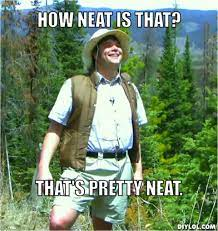

Важно: самый простой способ вставить картинку будет через Google Colab (даже если вы изначально делали не в нем). Нажмите на **"+ Text"**, в появившейся ячейке сделайте **прикрепление картинки** (как на скринах). Тогда ваша картинка "зашифруется" и будет корректно отображаться при конвертации в html

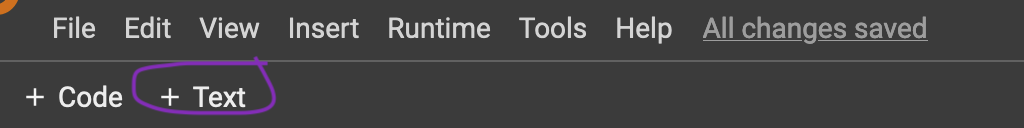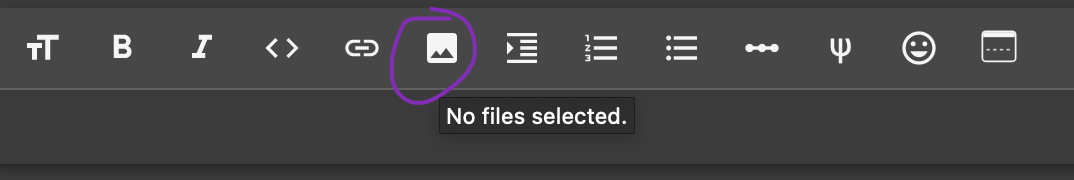

Ну что, детишки. Поздравляю с еще одним выполненным ДЗ!

